<a id='root'></a>
PyUltraLight 2.20 General Development Notebook

(3 May 2021)

* Y. Wang: [yourong.f.wang@auckland.ac.nz](mailto:yourong.f.wang@auckland.ac.nz)
* R. Easther
***



<a id='init'></a>
# Initialization and Program Settings

## Loading Packages

In [2]:
###### Do not touch
MinVersion = 20

import PyUltraLight2 as PyUL

if (PyUL.S_version < MinVersion):
    raise RuntimeError("You need the latest PyULN!")

PyUL.PyULCredits()

import numpy as np

np.set_printoptions(suppress=True)

import math

import numba
import numexpr as ne
import time
import pyfftw
import os
import sys
import multiprocessing
import numpy

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec
import matplotlib.animation
from matplotlib.offsetbox import AnchoredText

import scipy.fft

import h5py
import IPython
from IPython.core.display import clear_output, display, Video

from numpy import sqrt, exp, log, log10, sin, cos, tan, pi

G_phi = (sqrt(5)-1)/2

%reload_ext autoreload
%autoreload 2


# Useful Aux Functions
ToCode = PyUL.convert
ToPhys = PyUL.convert_back
CB = PyUL.convert_between

printU = PyUL.printU

save_path = '2021_Paper1'

PyUL2.21.1: (c) 2020 - 2021 Wang., Y. and collaborators. 
Auckland Cosmology Group

Original PyUltraLight Team:
Edwards, F., Kendall, E., Hotchkiss, S. & Easther, R.
arxiv.org/abs/1807.04037


## Visualization Preferences
Initialize the colorised representations for plots and movies.

### Publication

In [ ]:
plt.style.use('default')

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams["text.usetex"]= False
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.facecolor'] = 'w'

from matplotlib.colors import LinearSegmentedColormap
Palette = 'magma'
cyccol=['#000000', '#ffffff','#000000']
divcol=['#003262','#005b96','#ffffff','#d5a756','#B51700']
divcols=['#005b96','#ffffff','#d5a756']

CycPalette = LinearSegmentedColormap.from_list('myCyc', cyccol)

DivPalette  = LinearSegmentedColormap.from_list('myDiv', divcol)
DivPaletteS  = LinearSegmentedColormap.from_list('myDiv', divcols)

EFigSize = (20,12)
EFigSizeMono = (20,6)
VideoSize = (8,8)
FPS = 10
DPI = 72

FrameCap = 60 # Maximum Number of Frames to Animate

########################################

# BH Trajectory

Colors = np.array([[209,17,65],[0,177,89],[0,174,219],[243,119,53],[255,196,37]])/255

# NBody
ENStyle = '-.'
ENColor = '#ff6c0e' # NBody

EKColor = '#8dd9e7'
EPColor = '#fd8dc8'

# ULDM
EUStyle = '--'
EUColor = '#7f1717' # ULDM

EQColor = '#ccb603' # Kinetic 
ERColor = '#6cc25c' # Self-Interaction
EGColor = '#2c8899' # Particle Potential

# Totals
ETStyle = '-'
ETColor = '#080808'

# Auxiliary 
HelperStyle = 'k.'
EmphColor = 'black'
GeomColor = 'orange'

[**Back to the Top**](#root)
<a id='run'></a>
# Batch Analysis and Quick Analysis

This creates a timestamped folder using the current settings, and the integrator stores all requested files in it too.

## Parameter Scanning  / Batch Execution
<a id='scan'></a>
Please refer to the separate 'ParamScan' notebook for effective parameter scanning analysis.

In [ ]:
ExperimentName = '/Pub1_ERS_3'

batch_path = 'Batches'

PyUL.DSManagement(batch_path)

batch_path += ExperimentName

PyUL.DSManagement(batch_path)

In [ ]:
baseConfig = './Reusable/QDrag1_HD' # Path to base config file. won't be touched.
# Currently supported scan parameters: 
#Density, Resolution, TM_Mass, TM_vY, UVelY, Step_Factor, Scaling, Smoothing

ScanParams = ['Step_Factor','Smoothing']

ValuePool = [[0.2],[50,100,200,400,800,1600,3200,6400,12800]]

In [ ]:
printU('All files in the directory will be overwritten. Proceed? [Y]')

if input() == 'Y':
    NRuns, save_options = PyUL.ParameterScanGenerator(baseConfig,ScanParams,
                            ValuePool,batch_path, 
                           KeepSmooth = False,
                            KeepResol = False,
                           SaveSpace = False)

In [ ]:
FullSim = True
T0 = time.time()
runs = os.listdir(batch_path)
runs.sort()

Run = 0

for run_folder in runs:
    
    if os.path.isdir(f'{batch_path}/{run_folder}'):
        
        RunText = f'Simulation #{Run+1} out of {NRuns}'
        PyUL.evolve(batch_path,run_folder,
            NBodyInterp = FullSim, SelfGravity = FullSim, NBodyGravity = True, 
            Silent = True, Shift = False, AutoStop = True, AutoStop2 = False, Message = RunText)

        Run +=1

        print(f'Simulation {Run} finished.')
        time.sleep(2)
        
import IPython
IPython.display.Audio("Done.mp3",autoplay=True)

print(f"{time.time()-T0:.3f}s")

## [Dynamical Friction Workbench ParamScan]


This section is for Use with ** Dynamical Friction ** presets only.

### Initializing Journaling Variables

In [ ]:
NMI = len(MassIndex)
NDI = len(DensityIndex)

In [ ]:
DLog  = [] # Density
RLog  = [] # Resolution
MLog  = [] # Mass
BLog  = [] # Cutoff
TbLog = [] # NonDim_Cutoff
CLog  = [] # Dynamical Friction Coeff
SLog  = [] # Stopping Time Log
D1Log = [] # 1D Density Distribution
FTLog = [] # Final Location of TMMass in Length Units
G1Log = []
TpLog = [] # List of all time vectors (in case the last one stops.)

In [ ]:
batch_path = './Batches/' + PyUL.Runs('./Batches', Automatic = False)

runs = os.listdir(batch_path)
runs.sort()

Run = 0
for run_folder in runs:
    
    if os.path.isdir(f'{batch_path}/{run_folder}'):
        print(run_folder)
        
        TimeStamp = run_folder
        
        loc = f'{batch_path}/{run_folder}'
        print(loc,'\n')
        # Reload Config
        NS, central_mass, length, length_units, resol, duration, duration_units, step_factor, save_number, save_options, save_format, s_mass_unit, s_position_unit, s_velocity_unit, solitons,start_time, m_mass_unit, m_position_unit, m_velocity_unit, particles, embeds, Uniform,Density, density_unit ,a, B, UVel = PyUL.LoadConfig(loc)
        print(save_options)
        # Reload Output
        if save_number == -1:
            save_number = PyUL.DispN(duration,duration_units,length,length_units,resol,step_factor)

        EndNum, data, TMdata, phidata, graddata, phasedata = PyUL.Load_Data(batch_path,run_folder, save_options,save_number)

        Density1D = []
        Field1D = []
        for i in range(EndNum):
            OData = np.load(f'{loc}/Outputs/R1D_#{i:03d}.npy')/Density
            Density1D.append(OData)
            
        for i in range(EndNum):
            OData = np.load(f'{loc}/Outputs/F1D_#{i:03d}.npy')
            Field1D.append(OData)
  
        NBo = len(particles)

        ToCode = PyUL.convert
        ToPhys = PyUL.convert_back
        CB = PyUL.convert_between

        # Time
        durationMyr = ToPhys(ToCode(duration,duration_units,'t'),'Myr','t') * (EndNum-1) / save_number

        # Space
        lengthKpc = CB(length,length_units,'kpc','l')
        lengthC = ToCode(length,length_units,'l')

        # Mass

        MassList_MSol = []
        MassListSI = []
        for TM in particles:
            MassList_MSol.append(CB(TM[0],m_mass_unit,'M_solar_masses','m'))
            MassListSI.append(CB(TM[0],m_mass_unit,'kg','m'))
        
        mBH = MassList_MSol[0] # Million MSols
        mBH_kg = CB(mBH,'M_solar_masses','kg','m')

        
        
        if True:
            DLog.append(Density)
            RLog.append(resol)
            MLog.append(mBH)

            # Density
            densitySI = ToPhys(ToCode(Density,density_unit,'d'),'kg/m3','d')
            
            D1Log.append(np.array(Density1D))
            G1Log.append(np.array(Field1D))
            ## Misc. Pre-Multipliers

            Tp = np.linspace(0,EndNum-1,EndNum)
            Tp = Tp * durationMyr / (save_number+1)

            XPre = ToPhys(1,'kpc','l')
            VPre = ToPhys(1,'km/s','v')

            XPreSI = ToPhys(1,'m','l')
            VPreSI = ToPhys(1,'m/s','v')

            IArray = np.arange(len(TMdata[0]))

            # Dimensionful NBody State

            TMDataS = np.array(TMdata)
            TMDataSI = np.array(TMdata)

            TMDataS[:,IArray % 6 <= 2] *= XPre
            TMDataS[:,IArray % 6 >= 3] *= VPre

            TMDataSI[:,IArray % 6 <= 2] *= XPreSI
            TMDataSI[:,IArray % 6 >= 3] *= VPreSI

            # Rho data

            DPre = CB(1,density_unit,'kg/m3','d')

            # Energy
            EPre = PyUL.energy_unit

            # Field Strength
            PPre = PyUL.mass_unit / PyUL.length_unit

            ######### DYNFNB 2021-04-07
            vRel0 = -CB(UVel[1],s_velocity_unit,'m/s','v') + TMDataSI[:,4]

            lR = PyUL.hbar/(PyUL.axion_mass*vRel0) # Has a factor of 2pi removed.

            lRP = PyUL.convert_between(lR,'m','pc','l')

            # Quantum Mach Number

            MQ = 44.56*vRel0/1000*(((1e-22*PyUL.eV))/PyUL.axion_mass)/mBH/10

            beta = 2*np.pi*PyUL.G*mBH_kg/(vRel0[0])**2/(lR[0])

            # Reference Force Value

            FRel = 4*np.pi*Density*DPre*(PyUL.G*mBH*1e6*PyUL.solar_mass/(vRel0))**2

            print(f'Initial Relative Speed: {vRel0[0]:.4f} m/s\n\
            BH Mass: {mBH:.4f} Mil. MSol.')

            print(f"λ0 = {2*np.pi*lRP[0]/1000:.6g} kpc")

            print(f"M = {mBH_kg:.6g} kg")

            print(f"β = {beta:.6g}")

            print(f'Reference Force: {FRel[0]:.5g} N')

            SFC = PyUL.SliceFinderC

            def ySlice(i):

                RPt = SFC(TMdata[i],resol,lengthC,verbose = False)

                return RPt[1]

            # Time in seconds
            TpSec = CB(Tp,'Myr','s','t')

            # Motion due to Particle Movement
            dSim = TMDataSI[:,1] - TMDataSI[0,1]

            vQW = -1*CB(UVel[1],s_velocity_unit,'m/s','v')

            dQW = vQW*TpSec

            bSI = dQW + dSim

            bV = CB(bSI,'m','pc','l') 

            BVTilde = bV/lRP

            Lambda = BVTilde/beta

            # Expected DynDrag

            CLambda = np.log(2*Lambda) + 1/Lambda*np.log(2*Lambda) - 1

            TpSec = CB(Tp,'Myr','s','t')

            BLog.append(bV/length/1000)
            TbLog.append(BVTilde)

            # Gravitational Attraction of DM Wake
            CLogDF2 = -1*np.array(graddata)[:,1] * PyUL.length_unit/PyUL.time_unit**2 # 1 Code Acceleration Unit
            Crel = CLogDF2*vRel0**2/(4*np.pi*PyUL.convert_back(Density,'kg/m3','d')*PyUL.G**2*mBH_kg)

            CLog.append(Crel)
            clear_output()

            try:
                with open(f"{loc}/StoppingTime.uldm") as file:

                    StopTime = np.float(file.read())
            except FileNotFoundError:
                StopTime = -2

            if StopTime >= 0:
                StopTime = ToPhys(StopTime,duration_units,'t')
            SLog.append(StopTime)

            FTLog.append(TMDataS[-1,1])
            
            TpLog.append(Tp)
            
            clear_output()
                
print("Imported All Selected.", len(MLog))

In [ ]:
DensityIndex = np.linspace(4,8,9)
MassIndex = np.linspace(-2,2,5)

print(DensityIndex)

DensityPool = (10**DensityIndex).tolist()
MassPool = (10**MassIndex).tolist()

NDI = len(DensityPool)
NMI = len(MassPool)
colors = plt.cm.Spectral_r(np.linspace(0,1,NDI*NMI))


print(NDI,NMI)

### Dynamical Drag Main Framework

In [ ]:
BLine = np.linspace(-2,2,100)
BLineX = 10**BLine

rSys = PyUL.convert_between(length*BLineX,length_units,'m','l')

Lambda = vRel0[0]**2*rSys/(PyUL.G*mBH_kg)

# Classical B

C_Cl = np.log(2*Lambda) - 1 + 1/Lambda*np.log(2*Lambda)

F_Cl = 4*np.pi*PyUL.G**2*mBH_kg**2*Density*PyUL.convert_back(1,'kg/m3','d')/(vRel0[0]**2)*C_Cl / FRel[0]

# Classical A

C_A = (1+Lambda)/(Lambda)*np.arctanh(np.sqrt(Lambda**2+2*Lambda)/(1+Lambda)) - np.sqrt(1+2/Lambda)


#plt.loglog(BLineX,C_Cl,'--',label = 'Classical Dynamical Friction Limit B')

from scipy.special import sici as SiCin

Sb,Cb = SiCin(2*BLineX)

RealCb = np.euler_gamma + np.log(2*BLineX) - Cb

#plt.loglog(BLineX,1/3*BLineX**2,color = 'green',label = 'Lancaster Low b Asymptote')

from scipy.special import digamma as Dig

beta = PyUL.G*mBH_kg/(vRel0[0]**2*lR[0])

#plt.loglog(BLineX,np.log(2*BLineX)-1-np.real(Dig(1+1j*beta)),color = 'orange',label = 'Lancaster High b Asymptote')
plt.figure(figsize = (10,12),dpi = 72)

plt.loglog(BLineX,C_A,'--',
          color = EmphColor, label = 'Classical Limit')

plt.loglog(BLineX,RealCb+np.sin(2*BLineX)/(2*BLineX)-1,'-',
          color = EmphColor, label = 'Coulomb Reference')

for i in range(len(CLog)):


    plt.scatter(TbLog[i],CLog[i],
               color = colors[i])

    #plt.title(f'{i:02d}_Mass: {MLog[i]:.4g}; Density: {DLog[i]:.4g}')
    #plt.fill_betweenx(Crel,BCutTildeMin, BCutTildeMax,  color = 'r', alpha = 0.2)

    plt.xticks([0.1,1,10,100])
    plt.yticks([0.1,1,10])

    plt.xlabel('$\~{b} $')
    plt.ylabel('$C$ ')

    plt.ylim(0.001,500)

    plt.xlim(0.01,200)

    #plt.savefig(f'./Rampe/{i:02d}_{MLog[i]:.2g}_{DLog[i]:.2g}.png')
    print(f'{i:02d}',end='.')
plt.legend()

In [ ]:
plt.figure(figsize = (8,8),dpi = 144)

for i, Line in enumerate(CLog):

    Density = DLog[i]*PyUL.omega_m0
    
    DMag = int(np.floor(np.log10(Density)))
    DSf = np.round(Density/10**DMag,1)
    
    plt.semilogy(TpLog[i],Line,'-',
                 lw = 4, color = colors[i], alpha = 0.9)

plt.ylabel('$C$')
plt.xlabel('Time / Myr')

plt.ylim(0.01,100)

plt.legend(fontsize = 12, ncol = 1, title = '$\log_{10}({ρ}$/$ρ_{Crit})$')

In [ ]:
plt.figure(figsize = (16,12),dpi = 144)

for i, Line in enumerate(TbLog):
    
    Density = DLog[i]*PyUL.omega_m0
    
    DMag = int(np.floor(np.log10(Density)))
    DSf = np.round(Density/10**DMag,1)

    
    plt.plot(TpLog[i],Line,label = f'${DSf} × 10^{DMag}$', color = colors[i])

plt.ylabel('$\~{b}$')
plt.xlabel('Time / Myr')
plt.legend(fontsize = 11, ncol = 5, title = '${ρ}$/$ρ_{Crit}$')

### Maximum Drag Matrix

In [ ]:
figDM = plt.figure(figsize = (10,4))
plt.grid(alpha = 0.3)

MCLog = []
ci = 0
for i in zip(DLog,MLog,CLog):
    CMax = np.max(i[2])
    MCLog.append(CMax)
    plt.scatter(np.log10(i[0]),np.log10(i[1]), s = 200* CMax, 
                color = colors[ci],
               alpha = 0.7)
    plt.scatter(np.log10(i[0]),np.log10(i[1]), marker = 'x', color = EmphColor)
    
    ci += 1
    
plt.ylabel('$\log_{10}(M/10^6 M⊙)$')

plt.xlabel('$\log_{10}(ρ / ρ_{Crit})$')

plt.title(f'Size of Dot ∝ Max Friction')

In [ ]:
figST = plt.figure(figsize = (10,10))

MDMatrix = np.array(MCLog).reshape(NMI,NDI)

current_cmap = matplotlib.cm.binary
current_cmap.set_bad(color='blue')

plt.imshow((MDMatrix),cmap = current_cmap,origin = 'lower')

plt.yticks(np.arange(NMI),np.around(np.log10(MassPool),1))
plt.xticks(np.arange(NDI),np.around(np.log10(DensityPool),1))

plt.title(f"$v_0$ = {vRel0[0]:.3f} m/s")
plt.xlabel('$\log_{10}(M/10^6 M⊙)$')

plt.ylabel('$\log_{10}(ρ / ρ_{Crit})$')

plt.colorbar(label = '$C_{max}$', shrink = 0.6)

In [ ]:
fig = plt.figure(figsize = (16,16), dpi = DPI)
ax = fig.gca(projection='3d')

ax.view_init(35, -20)

ax.set_ylabel('$\log_{10}(M/10^6 M⊙)$',labelpad=10)

ax.set_xlabel('$\log_{10}(ρ / ρ_{Crit})$',labelpad=10)

ax.set_zlabel('$C_{max}$', labelpad=10)

yy,xx = np.meshgrid(MassIndex,DensityIndex)

# create the figure

ax.plot_surface(xx, yy, MDMatrix ,
        linewidth=5, alpha = 1, cmap = 'viridis')

ax.scatter(xx, yy, MDMatrix ,
        linewidth=5, alpha = 1, color = GeomColor)

# show it
plt.title(f"Maximum Dynamical Friction \n $v_0$ = {vRel0[0]:.3f} m/s")
plt.show()

In [ ]:
plt.figure(figsize = (4,8),dpi = 144)

RBC = (TbLog[0][-1])/1.2

print(RBC,'b')

Sb,Cb = SiCin(2*RBC)

RealCb = np.euler_gamma + np.log(2*RBC) - Cb

CL = RealCb+np.sin(2*RBC)/(2*RBC)-1


plt.xlabel('$\log_{10}(ρ / ρ_{Crit})$')
plt.ylabel('$C / C_{Coulumb}$')

print(MDMatrix.shape)

for i in range(NMI):
    plt.plot(DensityIndex + np.log10(PyUL.omega_m0),MDMatrix[:,i]/CL, 'o-',
            label = f'${np.log10(MassPool[i])+6:.0f}$',lw = 2,
                alpha = 0.85)

plt.plot(DensityIndex + np.log10(PyUL.omega_m0),0*DensityIndex+1, 'k--',)

plt.legend(fontsize = 12, title = '$\log_{10}($M/$M_⊙$)')

### Stopping Time Matrix

In [ ]:
figST = plt.figure(figsize = (10,10))
plt.grid(alpha = 0.3)

ci = 0
for i in zip(DLog,MLog,SLog):
    plt.scatter(np.log10(i[0]),np.log10(i[1]), s = 100*np.max([0,i[2]]),
                color = colors[ci],
               alpha = 0.7)
    plt.scatter(np.log10(i[0]),np.log10(i[1]), marker = 'x')
    
    ci += 1
    
plt.ylabel('$\log_{10}(M/10^6 M⊙)$')

plt.xlabel('$\log_{10}(ρ / ρ_{Crit})$')

plt.title(f'Size of Dot ∝ Stopping Time (if Within {duration:.3f} Myr)')

In [ ]:
figST = plt.figure(figsize = (10,10))
STMatrix = np.array(SLog).reshape(NMI, NDI)

STMatrix[STMatrix == -1] = np.nan
print(STMatrix)

current_cmap = matplotlib.cm.summer
current_cmap.set_bad(color='red')

plt.imshow((STMatrix),cmap = current_cmap, vmin = 0 , vmax = duration)

plt.yticks(np.arange(NMI),np.around(np.log10(MassPool),1))
plt.xticks(np.arange(NDI),np.around(np.log10(DensityPool)+np.log10(PyUL.omega_m0),1))

plt.title(f"$v_0$ = {vRel0[0]:.3f} m/s")
plt.xlabel('$\log_{10}(M/10^6 M⊙)$')

plt.ylabel('$\log_{10}(ρ / ρ_{Crit})$')

plt.colorbar(label = '$T_{Stop} \ / \  Myr$', shrink = 0.5)

In [ ]:
fig = plt.figure(figsize = (16,16), dpi = DPI)
ax = fig.gca(projection='3d')

ax.view_init(35, 20)

ax.set_xlabel('$\log_{10}(M/10^6 M⊙)$',labelpad=10)

ax.set_ylabel('$\log_{10}(ρ / ρ_{Crit})$',labelpad=10)

ax.set_zlabel('Stopping Time / Myr', labelpad=10)

xx,yy = np.meshgrid(MassIndex,DensityIndex)

# create the figure

ax.plot_surface(xx, yy, STMatrix ,
        linewidth=5, alpha = 1, vmin = 0, vmax = duration+1, cmap = 'viridis')

ax.scatter(xx, yy, STMatrix ,
        linewidth=5, alpha = 1, color = EmphColor)



# show it
plt.title(f"$v_0$ = {vRel0[0]:.3f} m/s")
plt.show()

### 1D Density and Field Slices

In [ ]:
for i in range(len(G1Log)):
    plt.figure(figsize = (8,8))
    plt.imshow(G1Log[i], aspect = 'auto')
    plt.title(f'ρ 1D: {DLog[i]:.3f}, {MLog[i]:.3f}')
    plt.xlabel('x / kpc')
    plt.ylabel('Time / Slices')
    plt.colorbar()
    plt.savefig(f'./Batches/Digest/AllGrav{i}.png')
    

In [ ]:
for i in range(len(D1Log)):
    plt.figure(figsize = (8,8))
    plt.imshow(D1Log[i], aspect = 'auto')
    plt.title(f'Φ 1D {DLog[i]:.3f}, {MLog[i]:.3f}')
    plt.xlabel('x / kpc')
    plt.ylabel('Time / Slices')
    plt.colorbar()
    plt.savefig(f'./Batches/Digest/AllDensity{i:03d}.png')

### 1D Comparator Plot

In [ ]:
plt.figure(figsize = (16,8))

plt.scatter([0],[0],color = 'k',s = 200)
plt.plot([np.mean(FTLog),0],[0,0],'k',linestyle = 'dashdot',
        label = 'Test mass trajectory')

# plt.scatter([CoollinePosition],[0],color = 'w',s = 200, edgecolor = 'k', lw = 6)

plt.quiver(np.mean(FTLog),[0],5,0)
plt.scatter(np.mean(FTLog),[0],s = 200,facecolor = 'w', edgecolor = 'k', lw = 4) 

GV = np.linspace(-lengthKpc/2,lengthKpc/2,resol,endpoint = False)

for i in range(len(D1Log)):  

    plt.plot(GV-FTLog[i],D1Log[i][-1,:]-1, lw = 3, alpha = i/12 )
    plt.fill_between(GV-FTLog[i],D1Log[i][-1,:]-1,0, alpha = 0.05, color = color)


plt.ylim(-0.005,0.03)
plt.xlim(-3.75,2)

#plt.title(f'Overdensity along $x$ axis at $t = {duration}${duration_units} ')

plt.ylabel('Overdensity')
plt.xlabel('x / kpc')

plt.legend()

plt.text(-0.5,0.013,'Increasing $ρ_0$ >>',rotation = 90,color = 'green')

plt.show()

In [ ]:
plt.figure(figsize = (16,8))

colors = plt.cm.viridis(np.linspace(0.4,1,12))

plt.scatter([0],[0],color = 'k',s = 200)
plt.plot([np.mean(FTLog),0],[0,0],'k',linestyle = 'dashdot',
        label = 'Test mass trajectory')

# plt.scatter([CoollinePosition],[0],color = 'w',s = 200, edgecolor = 'k', lw = 6)

plt.quiver(np.mean(FTLog),[0],5,0)
plt.scatter(np.mean(FTLog),[0],s = 200,facecolor = 'w', edgecolor = 'k', lw = 4) 

GV = np.linspace(-lengthKpc/2,lengthKpc/2,resol,endpoint = False)

for i in range(len(D1Log)):  
    
    print(D1Log[i].shape)
    
    color = colors[i]
    
    plt.plot(GV-FTLog[i],D1Log[i][-1,:]-1,color = color, lw = 3, alpha = i/12 )
    plt.fill_between(GV-FTLog[i],D1Log[i][-1,:]-1,0, alpha = 0.05, color = color)


plt.plot((GridVecL)/2/np.pi ,Hyp[resolA//2+OffsetH,:]-1,'k--',
         label = 'Coulomb Scattering',
        lw = 4)

plt.plot(GV-CoollinePosition,Coolline, label = 'Simulation Without Self-Gravity',
        lw = 4, alpha = 0.7,
        color = '#004ff2')

plt.ylim(-0.005,0.03)
plt.xlim(-3.75,2)

#plt.title(f'Overdensity along $x$ axis at $t = {duration}${duration_units} ')

plt.ylabel('Overdensity')
plt.xlabel('x / kpc')

plt.legend()

plt.text(-0.5,0.013,'Increasing $ρ_0$ >>',rotation = 90,color = 'green')

plt.show()

In [ ]:
plt.plot((GridVecL)/2/np.pi ,Hyp[resolA//2+OffsetH,:]-1,'k--',
         label = 'Coulomb Scattering',
        lw = 4)


In [ ]:
np.array(DLog)*PyUL.omega_m0

#### Load Perturbative Line

In [ ]:
Coolline = np.load(f"{loc}/Outputs/line_#{EndNum-1}.npy")/Density - 1

CoollinePosition = TMDataS[-1,1]


#### Prepare Analytical Curve

In [ ]:
from scipy.special import hyp1f1, gamma, factorial

print(PyUL.D_version)

import math
import time
import pyfftw
import os
import sys
import multiprocessing
from scipy.special import gamma

xLoc = PyUL.convert_between(TMDataSI[:,1],'m',length_units,'l') # The fixed Y Position

print(UVel, s_velocity_unit)

# Let's work everything in consistent astrophysical Units!.

Mass = MassListSI[0]

print(f'BH Mass is {Mass:.4g} kg')

vRel0 = -CB(UVel[1],s_velocity_unit,'m/s','v') + TMDataSI[:,4]

speed = vRel0[0] # m/s

lamb = 2*np.pi*PyUL.hbar/(PyUL.axion_mass*speed) # Full Quantum de Broglie

beta = 2*np.pi*(PyUL.G*Mass)/(speed**2*lamb) # Checked

print(f"de Broglie wavelength: {lamb:.5g} m\n\
Dimensionless Beta: {beta:.5g}")

lambKpc = PyUL.convert_between(lamb,'m',length_units,'l')

bound = length # Corresponding to the length we got. in User Units

resolA = 300

# Grid System for Analytical Result (Scaled Up by pi)

HyPSc = 4*np.pi # Scale down the sum to protect numerical convergence.

boundHyp = bound * 2 * np.pi / HyPSc

GridVec = np.linspace(-boundHyp,boundHyp,resolA,endpoint = False) 
GridVecL = np.linspace(-boundHyp*3,boundHyp,resolA*2,endpoint = False)

GridVecDisp = np.linspace(-bound,bound,resolA,endpoint = False) 
GridVecLDisp = np.linspace(-bound*3,bound,resolA*2,endpoint = False)

# Grid System for Simulations
GridVecR = np.linspace(-bound/2,bound/2,resol,endpoint = False)


vA,hA = np.meshgrid(GridVec,GridVecL,indexing = 'ij', sparse = True)

RArray = ne.evaluate('sqrt(vA*vA+hA*hA)')

SumLim = 172 # 172 is the maximum we can handle

ACom = beta*1j

BCom = 1

In = 1j*(RArray+hA)/lambKpc

Hyp = np.complex256(0)

for ii in range(SumLim):
    Hyp += gamma(ACom+ii)/gamma(ACom)/gamma(ii+1)**2*In**ii
    
    if ii == SumLim-1:
        print(gamma(ACom+ii)/gamma(ACom)/gamma(ii+1))
    
Hyp *= np.abs(gamma(1-beta*1j))

Hyp *= (np.exp(-1j*2*np.pi*hA/lambKpc + np.pi*beta/2))

Hyp *=  np.conj(Hyp)

plt.imshow(Hyp.real,cmap = Palette)

In [ ]:
Offset = 0

OffsetH = int(Offset*resolA*np.pi/resol)

fig, ax = plt.subplots(figsize = (16,9))

fig.patch.set_facecolor('white')
fig.patch.set_alpha(1)

ax.set_ylabel('Overdensity')
ax.set_xlabel('x / kpc')

print(Offset,OffsetH)

ax.plot(GridVecL/2/np.pi,Hyp[resolA//2+OffsetH,:],'-', label = 'Analytical Solution')

ax.scatter([0],[0],marker = 'x',color = 'k')

ax.set_ylim(np.min(PsiR)*1.5,np.max(PsiR)*1.5)

ax.legend()


## Energy Conservation Comparator

In [3]:
### Initializing Journaling Variables

TLog  = [] # Time
RLog  = [] # Resol
EDLog = [] # Total Energy Change
aLog = [] # Smoothing Factor
KLog = [] # EK
EULog = [] # ULD E
SFLog = [] # Smoothing 
LLog = [] # Box Length

In [4]:
batch_path = './Batches/' + PyUL.Runs('./Batches', Automatic = False)

runs = os.listdir(batch_path)
runs.sort()
Relative = True
Run = 0
for run_folder in runs:
    
    if os.path.isdir(f'{batch_path}/{run_folder}'):
        print(run_folder)
        TimeStamp = run_folder
        clear_output()
        loc = './' + batch_path + '/' + TimeStamp
        # Reload Config.. Why don't I use a class?
        NS, central_mass, length, length_units, resol, duration, duration_units, step_factor, save_number, save_options, save_format, s_mass_unit, s_position_unit, s_velocity_unit, solitons,start_time, m_mass_unit, m_position_unit, m_velocity_unit, particles, embeds, Uniform,Density, density_unit ,a, B, UVel = PyUL.LoadConfig(loc)

        if save_number == -1:
            sim_number = PyUL.ULDStepEst(duration,duration_units,
                                                  length,length_units,
                                                  resol,step_factor, 
                                                  save_number = -1)
        else:
            sim_number = save_number

        # Dict of Run Data
        EndNum, Loaded = PyUL.Load_npys(loc,save_options)

        TMdata = Loaded['NBody']
        linedata = Loaded['1Density']
        graddata = Loaded['DF']

        print(Loaded['Directory'])
        Loaded = {}

        NBo = len(particles)


        print(f'SIM NUMBER IS {sim_number}')
        # Time
        durationMyr = CB(duration,duration_units,'Myr','t') * (EndNum-1) / sim_number

        # Space
        lengthKpc = CB(length,length_units,'kpc','l')
        lengthC = ToCode(length,length_units,'l')

        # Mass

        MassList_MSol = []
        MassListSI = []
        for TM in particles:
            MassList_MSol.append(CB(TM[0],m_mass_unit,'M_solar_masses','m'))
            MassListSI.append(CB(TM[0],m_mass_unit,'kg','m'))

        # Density
        DensitySI = CB(Density,density_unit,'kg/m3','d')
        DensityC = ToCode(Density,density_unit,'d')

        ## Misc. Pre-Multipliers


        # NBody_State Vector

        XPre = ToPhys(1,'kpc','l')
        VPre = ToPhys(1,'km/s','v')

        XPreSI = ToPhys(1,'m','l')
        VPreSI = ToPhys(1,'m/s','v')

        IArray = np.arange(len(TMdata[0]))

        # Dimensionful NBody State

        TMDataS = np.array(TMdata)
        TMDataSI = np.array(TMdata)

        TMDataS[:,IArray % 6 <= 2] *= XPre
        TMDataS[:,IArray % 6 >= 3] *= VPre


        TMDataSI[:,IArray % 6 <= 2] *= XPreSI
        TMDataSI[:,IArray % 6 >= 3] *= VPreSI


        # Rho data
        DPre = CB(1,density_unit,'kg/m3','d')
        # Energy
        EPre = PyUL.energy_unit
        # Field Strength
        PPre = PyUL.mass_unit / PyUL.length_unit

        # Translating Snapshots back to Time
        timerange = np.linspace(0,durationMyr,save_number+1)

        Tp = np.arange(EndNum)

        print(Tp)

        Tp = Tp * durationMyr / (sim_number+1)

        print(Tp)

        # Raw ULDM Energy

        # Total Energy from Integrator
        egylist = np.load('{}{}'.format(loc, '/Outputs/egylist.npy'),allow_pickle=True) * EPre

        # Energy Due to N Body Potential
        egpcmlist =  np.load('{}{}'.format(loc, '/Outputs/egpcmMlist.npy'),allow_pickle=True) * EPre # NEW
        egpcmlist2 = np.load('{}{}'.format(loc, '/Outputs/egpcmlist.npy'),allow_pickle=True) * EPre # OLD

        # Energy Due to ULDM Self-Interaction
        egpsilist = np.load('{}{}'.format(loc, '/Outputs/egpsilist.npy'),allow_pickle=True) * EPre

        # Energy Due to Quantum Fun
        ekandqlist = np.load('{}{}'.format(loc, '/Outputs/ekandqlist.npy'),allow_pickle=True) * EPre

        mtotlist = np.load('{}{}'.format(loc, '/Outputs/masseslist.npy'),allow_pickle=True) * EPre

        # Uniform Correction Performed in Integrator!

        # Reconstruct NBody Energy (Real)
        NBo, KS, PS = PyUL.NBodyEnergy(MassListSI,TMDataSI,EndNum, a, length_units)

        # Reconstruct NBody Energy (Physical)
        # NBo, KS, PS = PyUL.NBodyEnergy(MassListSI,TMDataSI,EndNum)

        if Relative:
            K0 = KS[0] #  Need attention
            EUnit = '$E_k(0)$'

            if UVel != [0,0,0]:

                VRelSI = CB(np.linalg.norm(UVel),s_velocity_unit,'m/s','v')

                printU(f'Initial Relative Speed is {VRelSI:.3f} m/s','QW')

                K0 = 1/2*MassListSI[0]*(VRelSI)**2

        else: 
            K0 = 1
            EUnit = 'J'
        # Processed ULDM Energy

        MES = (PS + KS)
        MESD = PyUL.GetRel(MES)/K0

        EKQD = PyUL.GetRel(ekandqlist)/K0
        EGPD = PyUL.GetRel(egpsilist)/K0

        ECMD = PyUL.GetRel(egpcmlist)/K0
        ECOD = PyUL.GetRel(egpcmlist2)/K0

        KSD = PyUL.GetRel(KS)/K0
        PSD = PyUL.GetRel(PS)/K0

        EUOld  = egylist
        EUOldD = PyUL.GetRel(EUOld)/K0

        EUNew  = egpsilist + ekandqlist + egpcmlist2
        EUNewD = PyUL.GetRel(EUNew)/K0

        ETOld  = EUOld + MES
        ETOldD = PyUL.GetRel(ETOld)/K0

        ETNew  = EUNew + MES
        ETNewD = PyUL.GetRel(ETNew)/K0


        EROld = ETOld / ETOld[0]

        ERNew = ETNew / ETNew[0]
        LLog.append(lengthKpc)
        RLog.append(resol)
        TLog.append(Tp)
        EDLog.append(ERNew)
        KLog.append(MESD)
        EULog.append(EUNewD)
        SFLog.append(step_factor)                
        aLog.append(a)
        clear_output()
printU('Done!','IO')

PyUL2.   IO: Done!


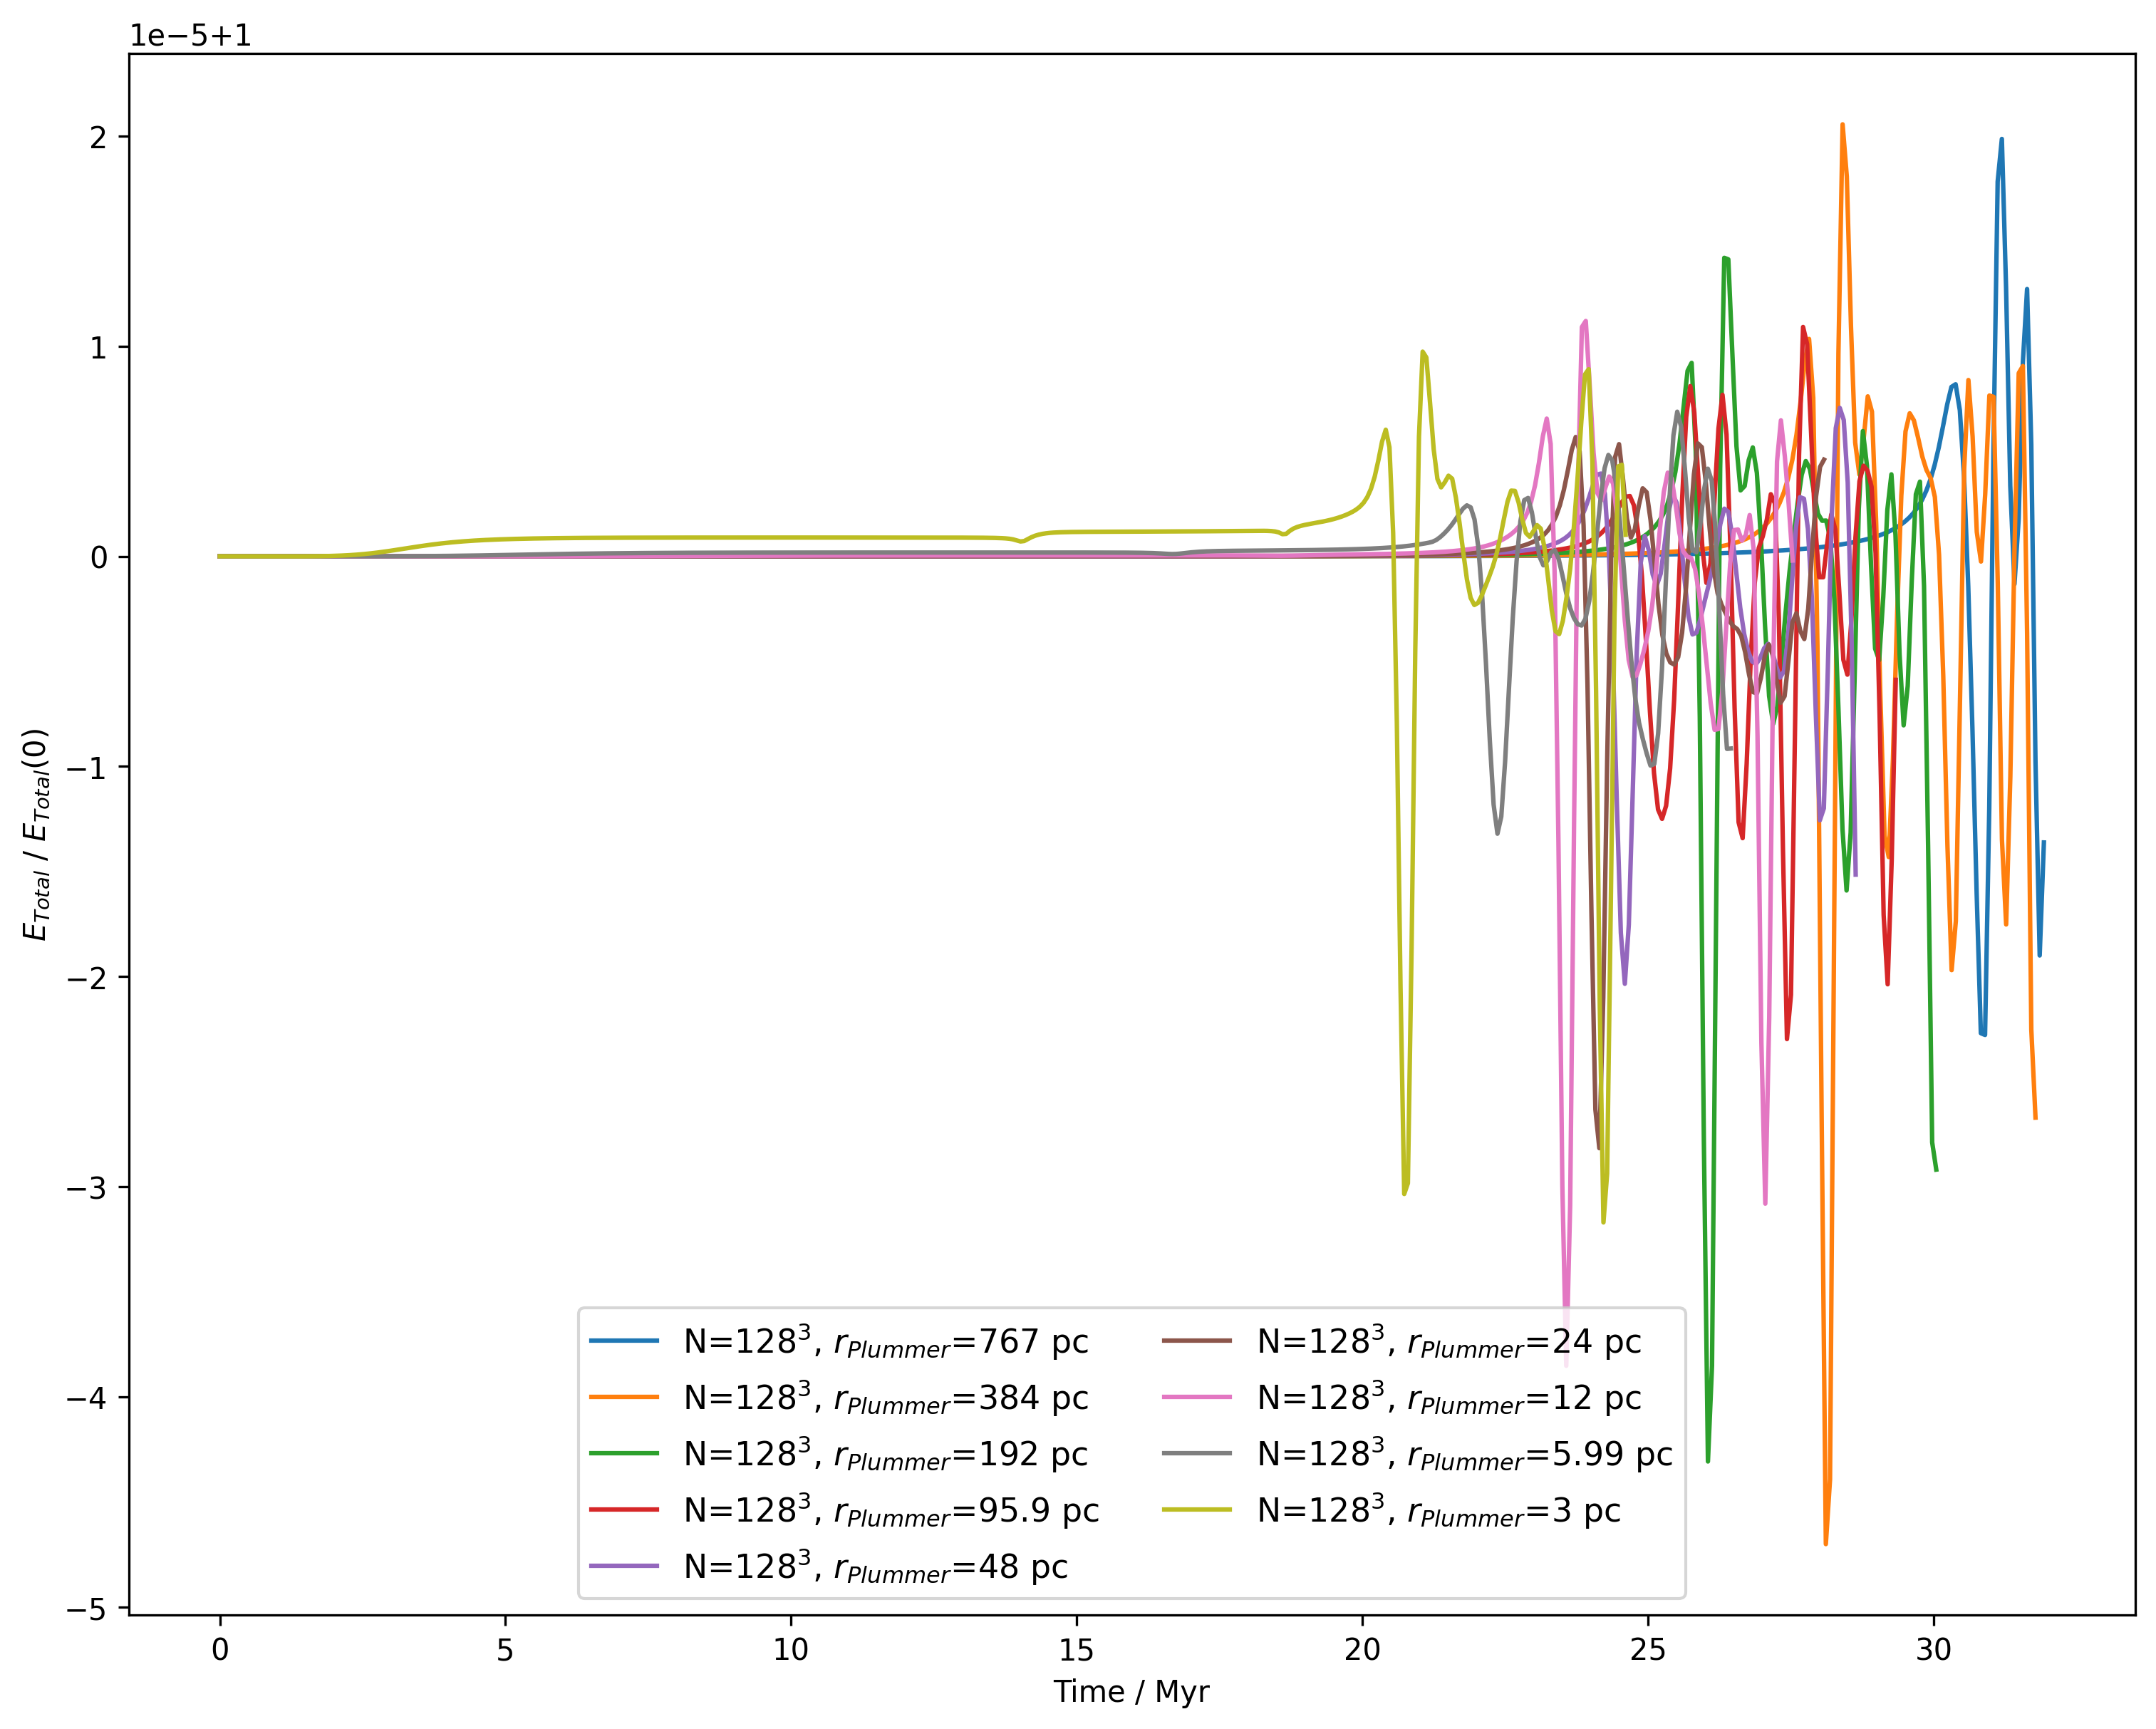

In [9]:
fig = plt.figure(figsize = (10,8), dpi = 300)

ax = fig.add_subplot(111)

plt.subplots_adjust(wspace=0, hspace=0)

j = -1
for i in zip(TLog,RLog,EDLog,EULog,KLog,aLog,SFLog,LLog):
    j += 1
    a = i[5]
        
    PR = 1/PyUL.convert(a,'pc','l')
    ax.plot(i[0],i[2],label = f'N={i[1]}$^3$, $r_{{Plummer}}$={PR:.3g} pc')



#ax.set_yticks([-0.01,0.,0.01])
#ax.set_yticklabels(['$-$1‱','0‱','1‱'])

ax.set_xlabel('Time / Myr')
ax.set_ylabel('$E_{Total}$ / $ E_{Total}(0)$')


plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

#plt.ylim([0.999998,1.000002])


ax.legend(ncol =2 ,loc = 8, fontsize = 11)

plt.show()

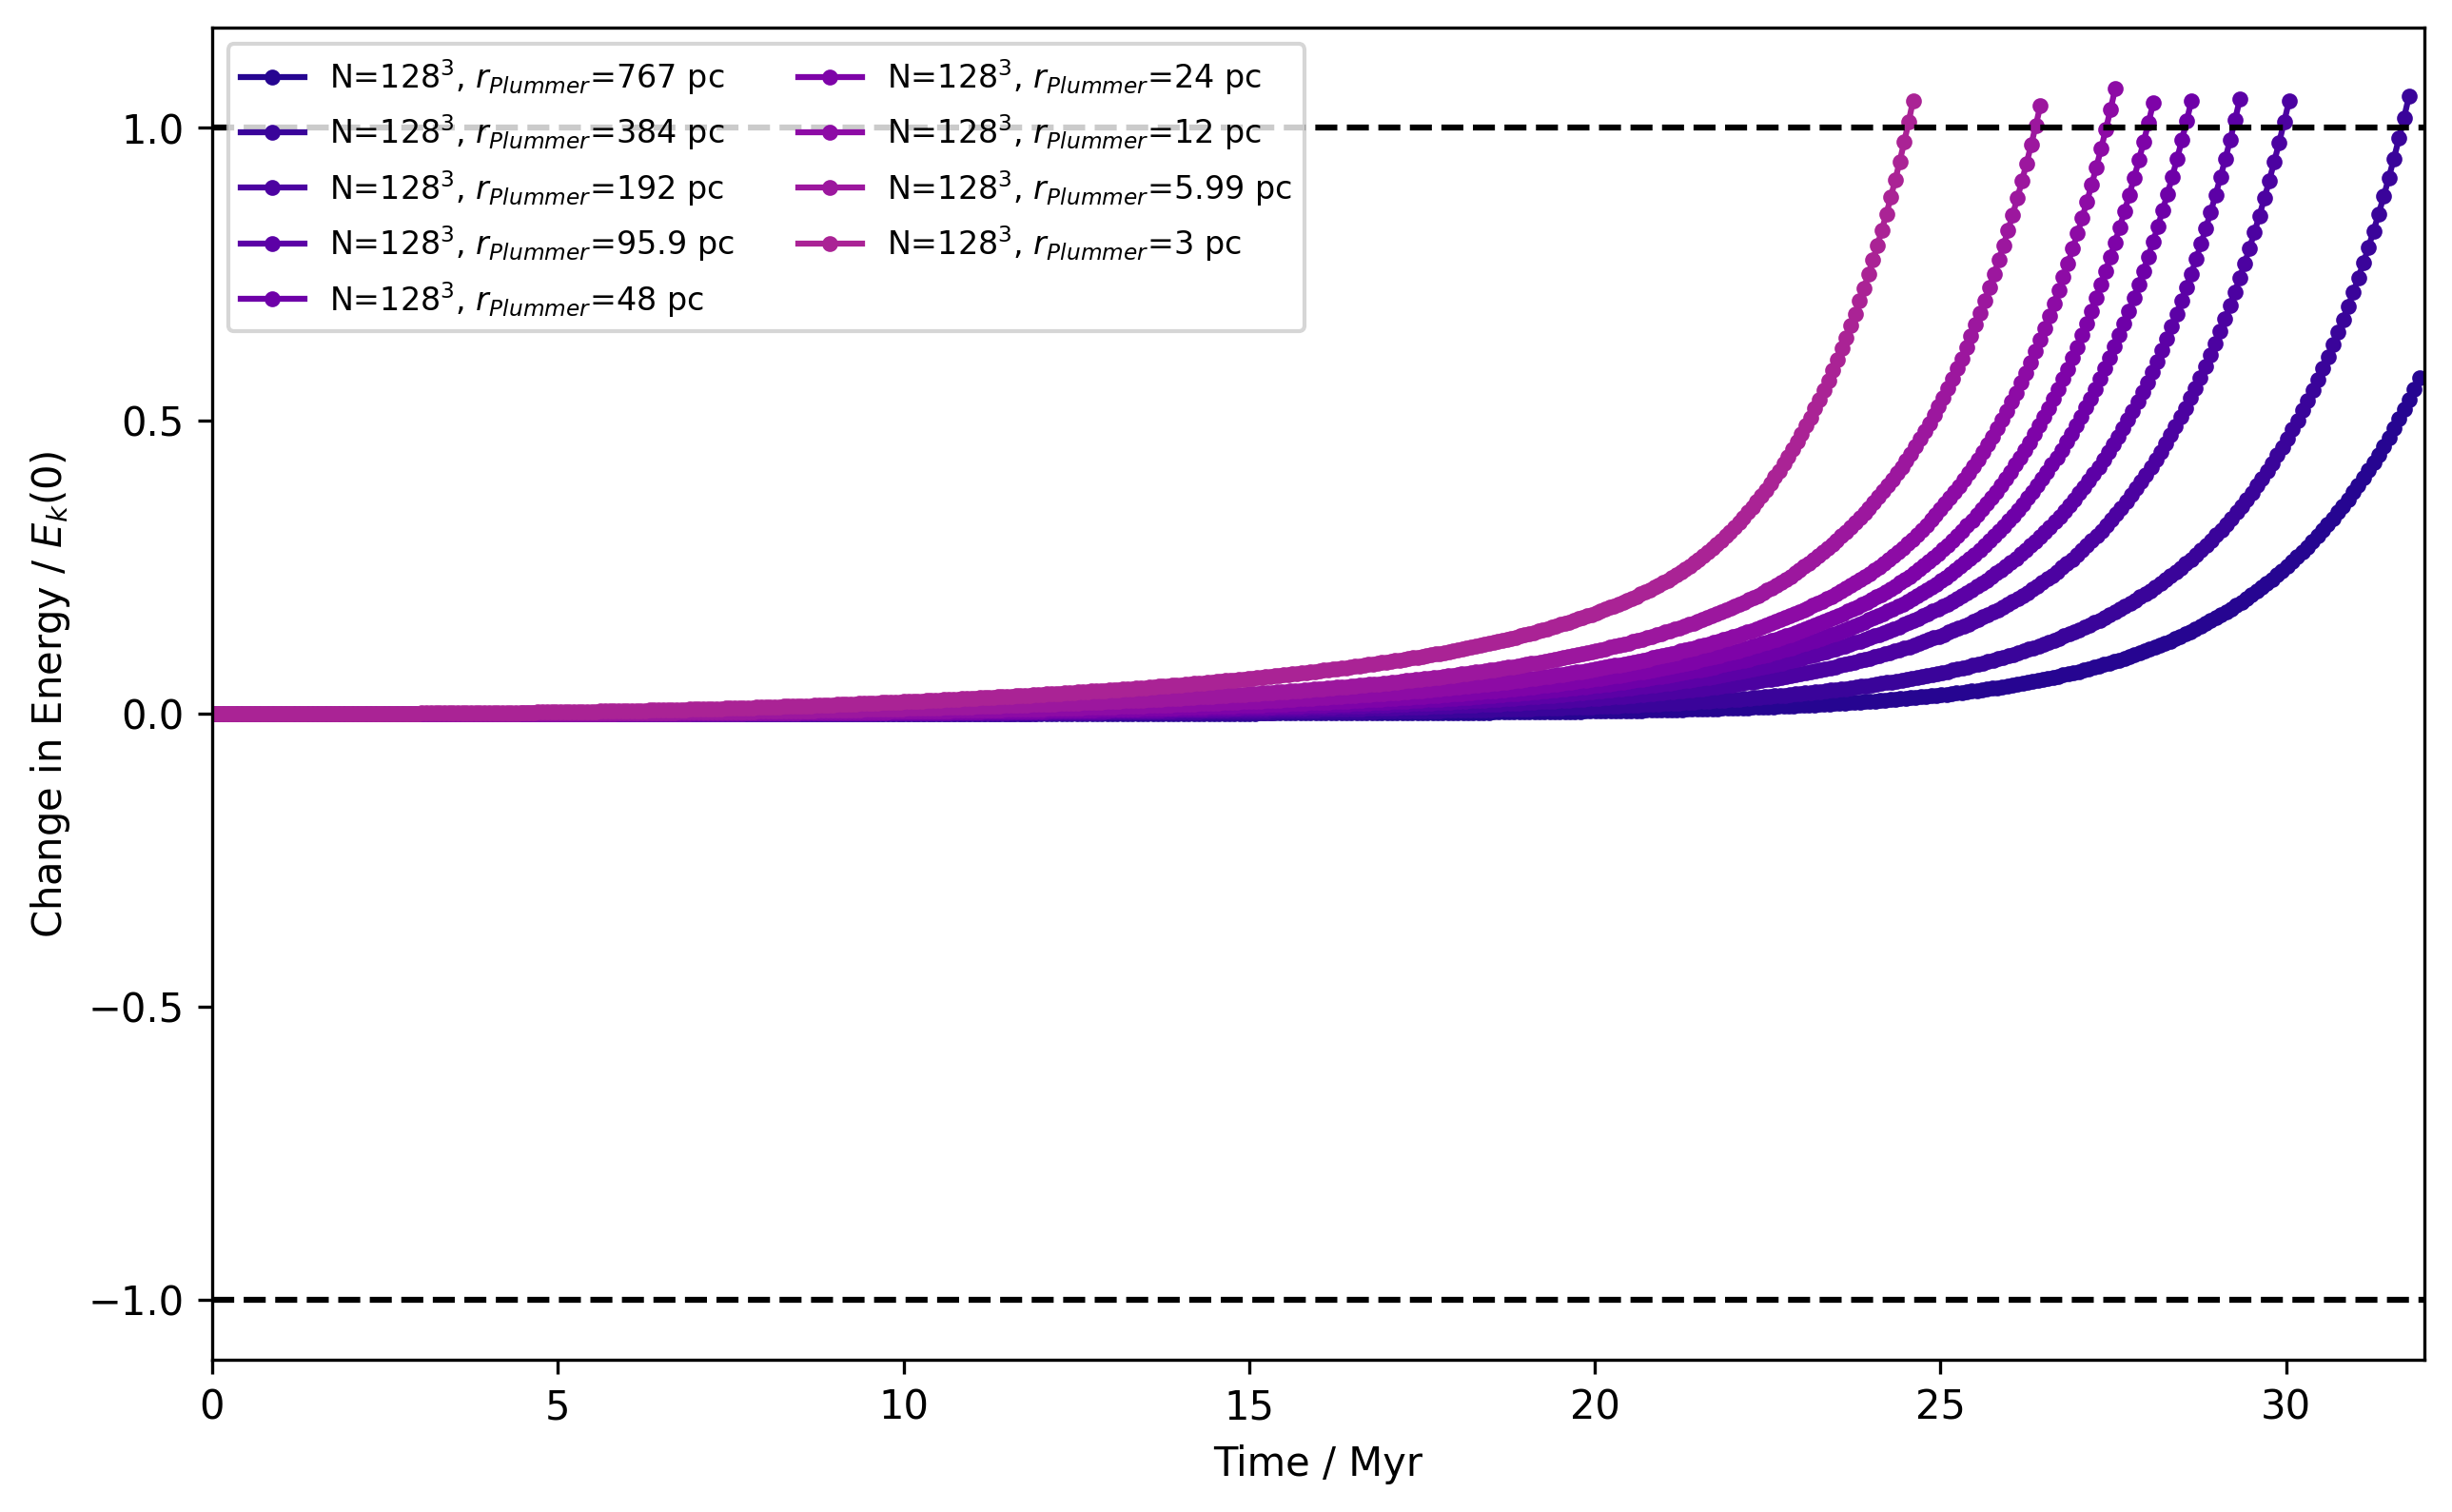

In [11]:
fig = plt.figure(figsize = (10,6.18), dpi = 300)
ax = fig.add_subplot(111)

EColors = plt.cm.plasma(np.linspace(0,1,25))
j = 0
for i in zip(TLog,RLog,EDLog,EULog,KLog,aLog,SFLog,LLog):

        
    a = i[5]

    PR = 1/PyUL.convert(a,'pc','l')

    j += 1
    ax.plot(i[0],i[4],'.-',label = f'N={i[1]}$^3$, $r_{{Plummer}}$={PR:.3g} pc', color = EColors[j])
'''
for i in range(9):
    plt.plot([TLog[i][-1],TLog[i+9][-1]],[-1,1],'k-')
'''

ax.plot([0,32],[-1,-1], 'k--')    
ax.plot([0,32],[1,1], 'k--') 

ax.set_ylabel(f'Change in Energy / {EUnit}')
plt.xlabel('Time / Myr')
plt.xlim(0,32)
plt.legend(fontsize = 8, ncol = 2)

## Multi Compare

This section is for Use with ** Dynamical Friction ** presets only.

In [14]:
DLog = []
TLog = []
CLog = []
MLog = []
YLog = []
ELog = []
XLog = []

In [16]:
batch_path = './Batches/' + PyUL.Runs('./Batches', Automatic = False)

# save_path = batch_path
TimeStamp = PyUL.Runs(batch_path)
clear_output()
loc = './' + batch_path + '/' + TimeStamp
# Reload Config.. Why don't I use a class?
NS, central_mass, length, length_units, resol, duration, duration_units, step_factor, save_number, save_options, save_format, s_mass_unit, s_position_unit, s_velocity_unit, solitons,start_time, m_mass_unit, m_position_unit, m_velocity_unit, particles, embeds, Uniform,Density, density_unit ,a, B, UVel = PyUL.LoadConfig(loc)

if save_number == -1:
    sim_number = PyUL.ULDStepEst(duration,duration_units,
                                          length,length_units,
                                          resol,step_factor, 
                                          save_number = -1)
else:
    sim_number = save_number
    
# Dict of Run Data
EndNum, Loaded = PyUL.Load_npys(loc,save_options)
TMdata = Loaded['NBody']
linedata = Loaded['1Density']
graddata = Loaded['DF']

print(Loaded['Directory'])
Loaded = {}

NBo = len(particles)

# Time
durationMyr = CB(duration,duration_units,'Myr','t') * (EndNum-1) / sim_number

# Space
lengthKpc = CB(length,length_units,'kpc','l')
lengthC = ToCode(length,length_units,'l')

# Mass

MassList_MSol = []
MassListSI = []
for TM in particles:
    MassList_MSol.append(CB(TM[0],m_mass_unit,'M_solar_masses','m'))
    MassListSI.append(CB(TM[0],m_mass_unit,'kg','m'))
    
# Density
DensitySI = CB(Density,density_unit,'kg/m3','d')
DensityC = ToCode(Density,density_unit,'d')

YLog.append(DensityC)

## Misc. Pre-Multipliers

Tp = np.linspace(0,EndNum-1,EndNum)
Tp = Tp * durationMyr / (sim_number+1)

# NBody_State Vector

XPre = ToPhys(1,'kpc','l')
VPre = ToPhys(1,'km/s','v')

XPreSI = ToPhys(1,'m','l')
VPreSI = ToPhys(1,'m/s','v')

IArray = np.arange(len(TMdata[0]))

# Dimensionful NBody State

TMDataS = np.array(TMdata)
TMDataSI = np.array(TMdata)

TMDataS[:,IArray % 6 <= 2] *= XPre
TMDataS[:,IArray % 6 >= 3] *= VPre


TMDataSI[:,IArray % 6 <= 2] *= XPreSI
TMDataSI[:,IArray % 6 >= 3] *= VPreSI


DLog.append(linedata)
MLog.append(TMDataS)

DPre = CB(1,density_unit,'kg/m3','d')
# DYNFRIC

vRel0 = -CB(UVel[1],s_velocity_unit,'m/s','v') + TMDataSI[:,4]

mBH = MassList_MSol[0] # Million MSols
mBH_kg = CB(mBH,'M_solar_masses','kg','m')

lR = PyUL.hbar/(PyUL.axion_mass*vRel0) # Has a factor of 2pi removed.

lRP = PyUL.convert_between(lR,'m','pc','l')

# Quantum Mach Number

MQ = 44.56*vRel0/1000*(((1e-22*PyUL.eV))/PyUL.axion_mass)/mBH/10

beta = 2*np.pi*PyUL.G*mBH_kg/(vRel0[0])**2/(lR[0])

# Reference Force Value

FRel = 4*np.pi*Density*DPre*(PyUL.G*mBH*1e6*PyUL.solar_mass/(vRel0))**2

# Time in seconds
TpSec = CB(Tp,'Myr','s','t')

# Motion due to Particle Movement
dSim = TMDataSI[:,1] - TMDataSI[0,1]

vQW = -1*CB(UVel[1],s_velocity_unit,'m/s','v')

dQW = vQW*TpSec

bSI = dQW + dSim

bV = CB(bSI,'m','pc','l')

BVTilde = bV/lRP

Lambda = BVTilde/beta

# Expected DynDrag

CLambda = np.log(2*Lambda) + 1/Lambda*np.log(2*Lambda) - 1


# Gravitational Attraction of DM Wake
CLogDF2 = -1*np.array(graddata)[:,1] * PyUL.length_unit/PyUL.time_unit**2 # 1 Code Acceleration Unit

# Phi is already in m/s^2 

Crel = CLogDF2*vRel0**2/(4*np.pi*CB(Density,density_unit,'kg/m3','d')*PyUL.G**2*mBH_kg)

PlotRange = np.linspace(-lengthKpc/2, lengthKpc/2,resol,endpoint = False)
# Exact Evaluation

from scipy.special import sici as SiCin

SbV,CbV = SiCin(2*BVTilde)

RealCbV = np.euler_gamma + np.log(2*BVTilde) - CbV

CrelV = RealCbV+np.sin(2*BVTilde)/(2*BVTilde)-1

CrelMax = np.max(Crel)

TLog.append(BVTilde)
CLog.append(Crel)

ELog.append(EndNum)

XLog.append(PlotRange)

Loaded = {}

The required number of ULDM steps is 434
The actual ULDM steps is 434
PyUL2.LoadNPY: Loaded 435 Data Entries from ././Batches/Pub1_ERS_3/PScan_F01_A01
././Batches/Pub1_ERS_3/PScan_F01_A01


### The 1-Dimensional Slice

In [ ]:
YLog

128 128
128 128
128 128
128 128
128 128


(0.0, 7.5)

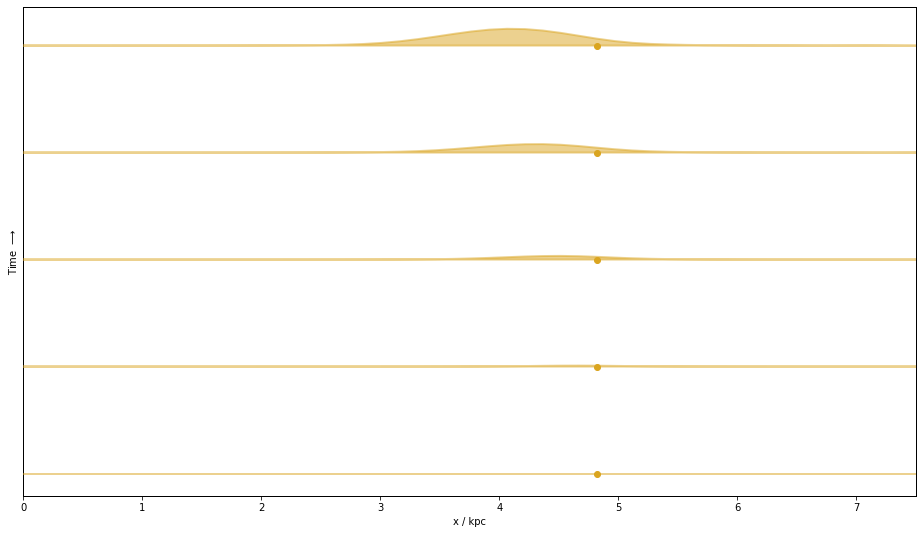

In [17]:
Step = 34
VOffset = 0.003
Sotal = EndNum // Step
Cutoff = 167


NSamples = len(DLog)

C1 = 'goldenrod'
C2 = 'darkolivegreen'
C3 = 'plum'
C4 = 'cadetblue'


Cs = [C1,C2,C3,C4]


fig = plt.figure(figsize = (16,9))

ax = fig.add_subplot(111)

plt.setp(ax.spines.values(), linewidth=1)

for i in range(Cutoff):
    if i%Step == 0:
        Alpha = 0.5
        LW = 2
        
        #plt.plot(PlotRange,0*PlotRange+1+VOffset*i,'--',alpha = 1, color = 'k', lw = 1)
        
        #plt.plot(PlotRange,DLog[0][i]/DensityC+VOffset*i,'-',alpha = Alpha, color = C1, lw = 3)
        #plt.plot(PlotRange,DLog[1][i]/DensityC+VOffset*i,'-',alpha = Alpha, color = C2, lw = 3)

            
        for J in range(NSamples):
            
            j = -J
            
            print(len(XLog[j]),len(DLog[j][i]))
            
            try:
                plt.fill_between(XLog[j],DLog[j][i]/YLog[j]+VOffset*i,1+VOffset*i,alpha = Alpha, color = Cs[J], 
                                 lw = LW, zorder = 100+j*10)
                
                plt.scatter([MLog[j][i,1]],[1+VOffset*i],c = Cs[J], alpha = 1, zorder = 300 + 20*J)

            except IndexError:
                print(f'Branch #{j} ran out of data points ({ENum[j]} vs. {i}).')
                continue

for j in range(NSamples):
    
    Cutoff = np.min([Cutoff,ELog[j]])
    
    #plt.plot(MLog[j][:Cutoff,1],np.arange(Cutoff)*VOffset+1,'-.', color = Cs[j], lw = 2, alpha = 0.5)
            
plt.ylabel(r'Time $\longrightarrow$')
plt.xlabel(r'x / kpc')
plt.yticks([])
plt.xlim(0.,7.5)

### Main Framework

In [ ]:
plt.figure(figsize = (10,8))

BLine = np.linspace(-2,3,300)

BLineX = 10**BLine

rSys = PyUL.convert_between(length*BLineX,length_units,'m','l')

Lambda = vRel0[0]**2*rSys/(PyUL.G*mBH_kg)

# Classical B

C_Cl = np.log(2*Lambda) - 1 + 1/Lambda*np.log(2*Lambda)

F_Cl = 4*np.pi*PyUL.G**2*mBH_kg**2*DensityC*PyUL.convert_back(1,'kg/m3','d')/(vRel0[0]**2)*C_Cl / FRel[0]

# Classical A

C_A = (1+Lambda)/(Lambda)*np.arctanh(np.sqrt(Lambda**2+2*Lambda)/(1+Lambda)) - np.sqrt(1+2/Lambda)


plt.loglog(BLineX,C_A,'--',
           color = EmphColor, label = 'Classical Dynamical Friction Limit')

#plt.loglog(BLineX,C_Cl,'--',label = 'Classical Dynamical Friction Limit B')

from scipy.special import sici as SiCin

Sb,Cb = SiCin(2*BLineX)

RealCb = np.euler_gamma + np.log(2*BLineX) - Cb

plt.loglog(BLineX,RealCb+np.sin(2*BLineX)/(2*BLineX)-1,
           color = EmphColor, label = 'Coulomb Scattering Result')

#plt.loglog(BLineX,1/3*BLineX**2,color = 'green',label = 'Lancaster Low b Asymptote')

from scipy.special import digamma as Dig

beta = PyUL.G*mBH_kg/(vRel0[0]**2*lR[0])


plt.scatter(TLog[0],CLog[0],label = 'Coulomb Simulation' ,  color = C1, s = 35, marker = 'x')
plt.scatter(TLog[1],CLog[1],label = 'Full Simulation' ,  color = C2, s = 35, marker = '1')
#plt.fill_betweenx(Crel,BCutTildeMin, BCutTildeMax,  color = 'r', alpha = 0.2)


plt.xticks([0.1,1,10,100,1000])
plt.yticks([0.1,1,10])

plt.xlabel('$\~{b} $')
plt.ylabel('$C$ ')

plt.ylim(0.005,300)

#plt.xlim(0.05,200)

plt.legend(ncol = 2, fontsize = 12)